In [1]:
run Lattice_functions.ipynb

In [7]:
import os
from functools import partial

path = os.getcwd()

np_load_old = partial(np.load)
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [2]:
nx = 4 + 1 # 1 added to make the total length = 20*0.01
ny = 4 + 1
lx = 0.25
ly = 0.25
k_inPlane = 2.5e4
nz = 3
lz = 0.01
k_vertical = 7e6
M2_5x5 = Rect_Lattice(nx, ny, lx, ly, k_inPlane, [], [], [])
M2_5x5 = add_braces_to_rectangular_lattice(M2_5x5, k_inPlane, '|')
M2_5x5 = add_layers_in_z_direction(M2_5x5, nz, lz, k_vertical, 0, [])

#setting z of the middle layer to zero and deriving support conditions:
min_x = M2_5x5.nodes[1].x
min_y = M2_5x5.nodes[1].y
max_x = M2_5x5.nodes[1].x
max_y = M2_5x5.nodes[1].y

for i in M2_5x5.nodes:
    i.z = round(i.z, 12) - lz
    i.x = round(i.x, 12)
    i.y = round(i.y, 12)
    min_x = min(i.x, min_x)
    min_y = min(i.y, min_y)
    max_x = max(i.x, max_x)
    max_y = max(i.y, max_y)

#Adding support
for i in M2_5x5.nodes:
    if(i.z == 0):
        if(i.x == min_x or i.x == max_x or i.y == min_y or i.y == max_y):
            i.s_x = 1
            i.s_y = 1
            i.s_z = 1
            M2_5x5.support_x.append(i.n)
            M2_5x5.support_y.append(i.n)
            M2_5x5.support_z.append(i.n)


mid_node = int(nx*ny + (nx*ny + 1)/2) #Only for odd nx and ny

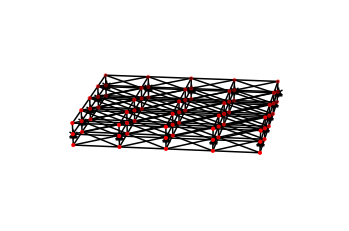

In [5]:
x0 = []
y0 = []
z0 = []
for i in M2_5x5.nodes:
    x0.insert((i.n - 1), i.x)
    y0.insert((i.n - 1), i.y)
    z0.insert((i.n - 1), i.z)
    
coord0 = x0 + y0 + z0
nNodes = int(len(coord0)/3)

ax = Lattice_Plot(x0, y0, z0, M2_5x5, [], 'XYs', 25, 8, 0.1, 'M2_type_a_3D')

In [21]:
forces_M2_AE_5x5 = np.load(path + '/Model 2/a/forces_M2_AE_5x5.npy')
forces_M2_5x5 = np.load(path + '/Model 2/a/forces_M2_5x5.npy')
z_centre_M2_5x5 = np.load(path + '/Model 2/a/z_centre_M2_5x5.npy')
z_centre_M2_AE_5x5 = np.load(path + '/Model 2/a/z_centre_M2_AE_5x5.npy')

In [22]:
#Equalizing the z for 2kN load
z_centre_M2_5x5 = -(-1*0.016312/z_centre_M2_5x5[4])*z_centre_M2_5x5
z_centre_M2_AE_5x5 = -(-1*0.016312/z_centre_M2_AE_5x5[4])*z_centre_M2_AE_5x5

In [23]:
w_FSDT = FSDPT_point_load_at_centre(2e6, 0.25, 0.02, 1, 1, 5/6, forces_M2_5x5, 20, 20)
w_FSDT = np.array(w_FSDT)

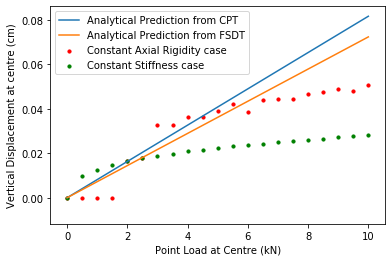

In [24]:
plt.scatter(forces_M2_AE_5x5, z_centre_M2_AE_5x5, c='r',s=10, label = "Constant Axial Rigidity case")
plt.scatter(forces_M2_5x5, z_centre_M2_5x5, c='g',s=10, label = "Constant Stiffness case")
plt.plot(forces_M2_5x5, 0.008156*forces_M2_5x5, label = "Analytical Prediction from CPT")
plt.plot(forces_M2_5x5, w_FSDT, label = "Analytical Prediction from FSDT")
plt.xlabel('Point Load at Centre (kN)') 
plt.ylabel('Vertical Displacement at centre (cm)')
plt.legend()
#plt.title ('Model 1 - Type A - vertical Displacement with repspect to Point Load at centre')
plt.savefig('M2_a_plt.png', dpi=300)
plt.show()

In [25]:
data_M2_5x5 = np.load(path + '/Model 2/a/data_M2_5x5.npy')
data_M2_AE_5x5 = np.load(path + '/Model 2/a/data_M2_AE_5x5.npy')

In [26]:
#Strain epsilon zz at the centre of the plate
mid_node = int(nx*ny + (nx*ny + 1)/2)
z_mid_node = 2*nNodes + mid_node - 1
epsilon_zz_vec = []
epsilon_zz_AE_vec = []
for i in range(0, len(data_M2_5x5)):
    epsilon = -100*(1 - (data_M2_5x5[i][2*nNodes + mid_node - 1 + nx*ny] - data_M2_5x5[i][2*nNodes + mid_node - 1 - nx*ny])/0.02)
    epsilon_AE = -100*(1 - (data_M2_AE_5x5[i][2*nNodes + mid_node - 1 + nx*ny] - data_M2_AE_5x5[i][2*nNodes + mid_node - 1 - nx*ny])/0.02)
    epsilon_zz_vec.append(epsilon)
    epsilon_zz_AE_vec.append(epsilon_AE)

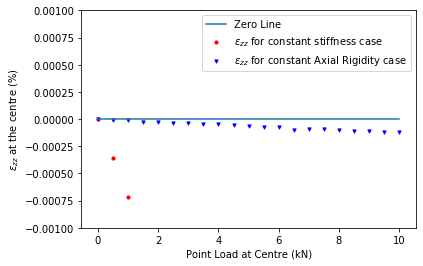

In [33]:
from matplotlib import rc
plt.scatter(forces_M2_AE_5x5, epsilon_zz_vec, c='r',s=10, label = "$\epsilon_{zz}$ for constant stiffness case")
plt.scatter(forces_M2_AE_5x5, epsilon_zz_AE_vec, marker = 'v', c='b',s=10, label = "$\epsilon_{zz}$ for constant Axial Rigidity case")
plt.plot(forces_M2_5x5, np.zeros(len(forces_M2_5x5)), label = "Zero Line")
plt.xlabel('Point Load at Centre (kN)') 
plt.ylabel('$\epsilon_{zz}$ at the centre (%)')
#plt.ylim(-0.0040,0.001)
plt.legend()
plt.savefig('M2_a_strain.png', dpi=300, bbox_inches = "tight")


In [28]:
#energy before and after
#setting z of the middle layer to zero and deriving support criterias:
min_x = M2_5x5.nodes[1].x
min_y = M2_5x5.nodes[1].y
max_x = M2_5x5.nodes[1].x
max_y = M2_5x5.nodes[1].y

for i in M2_5x5.nodes:
    i.z = round(i.z, 12) - lz
    i.x = round(i.x, 12)
    i.y = round(i.y, 12)
    min_x = min(i.x, min_x)
    min_y = min(i.y, min_y)
    max_x = max(i.x, max_x)
    max_y = max(i.y, max_y)

#Adding support
for i in M2_5x5.nodes:
    if(i.z == 0):
        if(i.x == min_x or i.x == max_x or i.y == min_y or i.y == max_y):
            i.s_x = 1
            i.s_y = 1
            i.s_z = 1
            M2_5x5.support_x.append(i.n)
            M2_5x5.support_y.append(i.n)
            M2_5x5.support_z.append(i.n)

f0 = Point_load_at_centre(0.5, M2_5x5)

In [29]:
energies_M2_5x5 = np.load(path + '/Model 2/a/energies_M2_5x5.npy')
energies_M2_AE_5x5 = np.load(path + '/Model 2/a/energies_M2_AE_5x5.npy')
E_before = []
for i in range(1, 22):
    print(i)
    f = (i - 1)*f0
    E_before.append(Energy(coord0, f, M2_5x5))
    
for i in range(1, len(energies_M2_5x5)):
    energies_M2_5x5[i] = energies_M2_5x5[i] - E_before[i]
    energies_M2_AE_5x5[i] = energies_M2_AE_5x5[i] - E_before[i]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


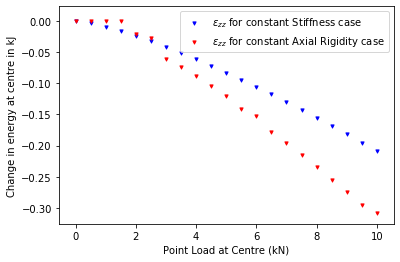

In [30]:
from matplotlib import rc
#plt.scatter(forces_M2_AE_5x5, E_before, c='r',s=10, label = "$\epsilon_{zz}$ for constant stiffness case")
plt.scatter(forces_M2_AE_5x5, energies_M2_5x5, marker = 'v', c='b',s=10, label = "$\epsilon_{zz}$ for constant Stiffness case")
plt.scatter(forces_M2_AE_5x5, energies_M2_AE_5x5, marker = 'v', c='r',s=10, label = "$\epsilon_{zz}$ for constant Axial Rigidity case")
#plt.plot(forces_M2_5x5, 0*np.ones(len(forces_M2_5x5)), label = "Energy in undef")
plt.xlabel('Point Load at Centre (kN)') 
plt.ylabel('Change in energy at centre in kJ')
#plt.ylim(-0.0050+1e2,0.001+1e2)
plt.legend()
plt.savefig('M2_a_energy.png', dpi=300, bbox_inches = "tight")


In [ ]:
np.load = np_load_old